# Noisy QCNN demos

This demo uses 4-qubit Quantum Convolutional Neural Network (QCNN) to see how pre-training the quantum embedding can be helpful for training a parameterized QML circuits for classfication tasks.

If you are interested in detailed analysis of pre-training on 8-qubit device, check out "/Result/earlystop 10 experiments/" folder.

If you are interested in the details about the QCNN used in this demo, check out https://arxiv.org/pdf/2108.00661.pdf.


In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

IBMQ Fake provider

In [2]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import IBMQ
from qiskit.providers.fake_provider import FakeJakarta, FakeMontreal
from qiskit_aer.noise import NoiseModel


noisy = FakeJakarta()
noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev_fake = qml.device(
    'qiskit.aer',
    wires=4,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

"""
Use below for Real Device
TOKEN_tak = "798c4f141e8fa071c14823a956f816c8dda622f9f00b95cae62cc5b1a3105b4fe4845a234d661f20281f6b77ac0299e3c4367f6a3b58db16c36bcde3a9cb1151"
TOKEN_dkp = "3ae7ac10f40eb88c7ebb0eca20aa0788e7a96da729e2c3848d9864684362aaf50dfdda7cb3ec1ffd75eb7ed5b44f7c14f2f17419cf600ce14437ee7cd00ac75b"

IBMQ.save_account(token=TOKEN_dkp, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku')
backend = "ibmq_jakarta"

dev_jakarta = qml.device(
    'qiskit.ibmq',
    wires=4,
    shots=1024,
    backend=backend,
    provider=provider
)
"""

'\nUse below for Real Device\nTOKEN_tak = "798c4f141e8fa071c14823a956f816c8dda622f9f00b95cae62cc5b1a3105b4fe4845a234d661f20281f6b77ac0299e3c4367f6a3b58db16c36bcde3a9cb1151"\nTOKEN_dkp = "3ae7ac10f40eb88c7ebb0eca20aa0788e7a96da729e2c3848d9864684362aaf50dfdda7cb3ec1ffd75eb7ed5b44f7c14f2f17419cf600ce14437ee7cd00ac75b"\n\nIBMQ.save_account(token=TOKEN_dkp, overwrite=True)\nIBMQ.load_account()\nprovider = IBMQ.get_provider(hub=\'ibm-q-skku\')\nbackend = "ibmq_jakarta"\n\ndev_jakarta = qml.device(\n    \'qiskit.ibmq\',\n    wires=4,\n    shots=1024,\n    backend=backend,\n    provider=provider\n)\n'

# Noisy Model1 & Model 2

## 0. Getting Started

Load the dataset for Model1 and Model2

In [3]:
dev = qml.device('default.qubit', wires=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new.to(device), X2_new.to(device), Y_new.to(device)

## Part1: Pre-training the embedding

In [4]:
@qml.qnode(dev_fake, interface="torch")
def Noisy_Four_circuit1(inputs): 
    embedding.Noisy_Four_QuantumEmbedding1(inputs[0:4])
    embedding.Noisy_Four_QuantumEmbedding1_inverse(inputs[4:8])
    return qml.probs(wires=range(4))

@qml.qnode(dev_fake, interface="torch")
def Noisy_Four_circuit2(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs[0:7])
    embedding.Noisy_Four_QuantumEmbedding2_inverse(inputs[7:14])
    return qml.probs(wires=range(4))


class Noisy_Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Noisy_Four_circuit1, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]


class Noisy_Model2_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Noisy_Four_circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer2(x)
        return x[:,0]


class Noisy_Model3_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Noisy_Four_circuit2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc(x2)

        x = torch.concat([x1, x2], 1)
        x = self.qlayer3(x)
        return x[:,0]

(Skip the code below, Already trained)

In [5]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Noisy_Model1_Fidelity':
        model = Noisy_Model1_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model1_Fidelity.pt'
    elif model_name == 'Noisy_Model2_Fidelity':
        model = Noisy_Model2_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model2_Fidelity.pt'
    elif model_name == 'Noisy_Model3_Fidelity':
        model = Noisy_Model3_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model3_Fidelity.pt'

    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(600):

        X1_batch, X2_batch, Y_batch = new_data(10, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 200 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)

train_models('Noisy_Model1_Fidelity')
train_models('Noisy_Model2_Fidelity')


/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_33203/2657414107.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/torch/csrc/utils/tensor_new.cpp:233.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


Iterations: 0 Loss: 0.22148370742797852
Iterations: 200 Loss: 0.06752805411815643
Iterations: 400 Loss: 0.08619680255651474
Iterations: 0 Loss: 0.25259408354759216
Iterations: 200 Loss: 0.04358730465173721
Iterations: 400 Loss: 0.03003225289285183


Calculate the distances of Test dataset with the pre-trained quantum embeddings. From the calculated trace distance gain the lower bound of the linear loss function (with respect to the test data).

In [6]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)


@qml.qnode(dev, interface="torch")
def Noisy_Distance1(inputs): 
    embedding.Noisy_Four_QuantumEmbedding1(inputs)
    return qml.density_matrix(wires=range(4))

@qml.qnode(dev, interface="torch")
def Noisy_Distance2(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))


class Distances1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Noisy_Distance1, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack1(x1)
        x0 = self.linear_relu_stack1(x0)
        rhos1 = self.qlayer1(x1)
        rhos0 = self.qlayer1(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


class Distances2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Noisy_Distance2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack2(x1)
        x0 = self.linear_relu_stack2(x0)
        rhos1 = self.qlayer2(x1)
        rhos0 = self.qlayer2(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


class Distances3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Noisy_Distance2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
    
    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc(x0)

        rhos1 = self.qlayer3(x1)
        rhos0 = self.qlayer3(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


PATH_Model1 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model1_Fidelity.pt'
PATH_Model2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model2_Fidelity.pt'
PATH_Model3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model3_Fidelity.pt'
Model1_Fidelity_Distance = Distances1().to(device)
Model1_Fidelity_Distance.load_state_dict(torch.load(PATH_Model1, map_location=device))
Model2_Fidelity_Distance = Distances2().to(device)
Model2_Fidelity_Distance.load_state_dict(torch.load(PATH_Model2, map_location=device))

# Calculated from Model1 
Trace_before_traindata = 0.2734867334365845
Trace_before_testdata = 0.2723434865474701
LB_before_traindata = 0.5 * (1 - Trace_before_traindata)

print(f"Trace Distance (Training Data) Before: {Trace_before_traindata}")
print(f"Trace Distance (Test Data) Before: {Trace_before_testdata}")

# Distances After training with Model2_Fidelity
Trace_Model1_traindata = Model1_Fidelity_Distance(X1_train, X0_train)
Trace_Model1_testdata = Model1_Fidelity_Distance(X1_test, X0_test)
print(f"Trace Distance (Training Data) After Noisy Model1 Fidelity: {Trace_Model1_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model1 Fidelity: {Trace_Model1_testdata}")

# Distances After training with Model2_HSinner
Trace_Model2_traindata = Model2_Fidelity_Distance(X1_train, X0_train)
Trace_Model2_testdata = Model2_Fidelity_Distance(X1_test, X0_test)
print(f"Trace Distance (Training Data) After Noisy Model2 Fidelity: {Trace_Model2_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model2 Fidelity: {Trace_Model2_testdata}")

# Lower Bounds
LB_before_traindata = 0.5 * (1 - Trace_before_traindata)
LB_Model1_traindata = 0.5 * (1 - Trace_Model1_traindata.detach().numpy())
LB_Model2_traindata = 0.5 * (1 - Trace_Model2_traindata.detach().numpy())

Trace Distance (Training Data) Before: 0.2734867334365845
Trace Distance (Test Data) Before: 0.2723434865474701


/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance (Training Data) After Noisy Model1 Fidelity: 0.9132198095321655
Trace Distance (Test Data) After Noisy Model1 Fidelity: 0.9239969253540039
Trace Distance (Training Data) After Noisy Model2 Fidelity: 0.7868266701698303
Trace Distance (Test Data) After Noisy Model2 Fidelity: 0.7931129336357117


# Part2: Training QCNN with/without Pre-trained embedding

Relabel the datasets

In [7]:
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [8]:
class x_transform1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )

    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()


class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model1 = x_transform1().to(device)
model2 = x_transform2().to(device)
model3 = x_transform3().to(device)

Tunable Hyperparameters

In [9]:
steps = 600
learning_rate = 0.01
batch_size = 10
ansatz = 'TTN'
#ansatz = 'SU4'

In [10]:
def statepreparation(x, Trained):
    if Trained == False:
        embedding.Noisy_Four_QuantumEmbedding1(x)
    if Trained == 'Model1_Fidelity':
        model1.load_state_dict(torch.load(PATH_Model1, map_location=device))
        x = model1(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding1(x)
    elif Trained == 'Model2_Fidelity':
        model2.load_state_dict(torch.load(PATH_Model2, map_location=device))
        x = model2(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding2(x)
    elif Trained == 'Model3_Fidelity':
        model3.load_state_dict(torch.load(PATH_Model3, map_location=device))
        x = model3(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding2(x[0])
    

@qml.qnode(dev_fake)
def Noisy_QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    embedding.Noisy_QCNN_four(params, ansatz)
    return qml.expval(qml.PauliZ(2))


def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)


def cost(weights, X_batch, Y_batch, Trained):
    preds = [Noisy_QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, Trained):

    if ansatz == 'SU4':
        num_weights = 30
    elif ansatz == 'TTN':
        num_weights = 4

    weights = np.random.random(num_weights, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 200 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [11]:
Loss_histories_not_trained, weights_not_trained, Loss_histories_Model1_Fidelity, weights_Model1_Fidelity, Loss_histories_Model2_Fidelity, weights_Model2_Fidelity = [], [], [], [], [], []
for i in range(5):
    loss_not_trained, weight_not_trained = circuit_training(X_train, Y_train, False)
    loss_Model1_Fidelity, weight_Model1_Fidelity = circuit_training(X_train, Y_train, 'Model1_Fidelity')
    loss_Model2_Fidelity, weight_Model2_Fidelity = circuit_training(X_train, Y_train, 'Model2_Fidelity')

    Loss_histories_not_trained.append(loss_not_trained)
    Loss_histories_Model1_Fidelity.append(loss_Model1_Fidelity)
    Loss_histories_Model2_Fidelity.append(loss_Model2_Fidelity)

    weights_not_trained.append(weight_not_trained)
    weights_Model1_Fidelity.append(weight_Model1_Fidelity)
    weights_Model2_Fidelity.append(weight_Model2_Fidelity)

Loss_histories_not_traiend, Loss_histories_Model1_Fidelity, Loss_histories_Model2_Fidelity =  np.array(Loss_histories_not_trained), np.array(Loss_histories_Model1_Fidelity), np.array(Loss_histories_Model2_Fidelity)

Not_trained_mean, Not_trained_std = Loss_histories_not_traiend.mean(axis=0), Loss_histories_not_traiend.std(axis=0)
Model1_Fidelity_mean, Model1_Fidelity_std = Loss_histories_Model1_Fidelity.mean(axis=0), Loss_histories_Model1_Fidelity.std(axis=0)
Model2_Fidelity_mean, Model2_Fidelity_std = Loss_histories_Model2_Fidelity.mean(axis=0), Loss_histories_Model2_Fidelity.std(axis=0)

/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/tak/miniforge3/envs/QC/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


iteration:  0  cost:  0.47236328125
iteration:  200  cost:  0.46650390625
iteration:  400  cost:  0.47841796875


/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_33203/3324442140.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model1(torch.tensor(x))


iteration:  0  cost:  0.4744140625
iteration:  200  cost:  0.4154296875
iteration:  400  cost:  0.35615234375


/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_33203/3324442140.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model2(torch.tensor(x))


iteration:  0  cost:  0.4908203125
iteration:  200  cost:  0.437890625
iteration:  400  cost:  0.4421875
iteration:  0  cost:  0.48974609375
iteration:  200  cost:  0.49853515625
iteration:  400  cost:  0.42119140625
iteration:  0  cost:  0.5154296875
iteration:  200  cost:  0.3833984375
iteration:  400  cost:  0.3560546875
iteration:  0  cost:  0.5099609375
iteration:  200  cost:  0.36513671875
iteration:  400  cost:  0.30673828125
iteration:  0  cost:  0.49326171875
iteration:  200  cost:  0.5427734375
iteration:  400  cost:  0.48984375
iteration:  0  cost:  0.47763671875
iteration:  200  cost:  0.423046875
iteration:  400  cost:  0.31025390625
iteration:  0  cost:  0.471875
iteration:  200  cost:  0.44326171875
iteration:  400  cost:  0.437109375
iteration:  0  cost:  0.54296875
iteration:  200  cost:  0.55126953125
iteration:  400  cost:  0.50146484375
iteration:  0  cost:  0.4904296875
iteration:  200  cost:  0.4337890625
iteration:  400  cost:  0.317578125
iteration:  0  cost:  0

Check the accuracies for Noisy QCNN classifiers

In [12]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_not_trained, accuracies_Model1_Fidelity, accuracies_Model2_Fidelity = [], [], []

for i in range(5):
    prediction_not_trained = [Noisy_QCNN_classifier(weights_not_trained[i], x, Trained=False) for x in X_test]
    prediction_Model1_Fidelity = [Noisy_QCNN_classifier(weights_Model1_Fidelity[i], x, Trained='Noisy_Model1_Fidelity') for x in X_test]
    prediction_Model2_Fidelity = [Noisy_QCNN_classifier(weights_Model2_Fidelity[i], x, Trained='Noisy_Model2_Fidelity') for x in X_test]
    
    accuracy_not_trained = accuracy_test(prediction_not_trained, Y_test)
    accuracy_Model1_Fidelity = accuracy_test(prediction_Model1_Fidelity, Y_test)
    accuracy_Model2_Fidelity = accuracy_test(prediction_Model2_Fidelity, Y_test)

    accuracies_not_trained.append(accuracy_not_trained)
    accuracies_Model1_Fidelity.append(accuracy_Model1_Fidelity)
    accuracies_Model2_Fidelity.append(accuracy_Model2_Fidelity)

accuracies_not_trained = np.array(accuracies_not_trained)
accuracies_Model1_Fidelity, accuracies_Model2_Fidelity = np.array(accuracies_Model1_Fidelity), np.array(accuracies_Model2_Fidelity)

# Noisy Model3

## 0. Getting Started

Load the dataset for Model3

In [13]:
dev = qml.device('default.qubit', wires=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new.to(device), X2_new.to(device), Y_new.to(device)

## Part1: Pre-training the embedding

In [14]:
train_models('Noisy_Model3_Fidelity')

Iterations: 0 Loss: 0.46653422713279724
Iterations: 200 Loss: 0.45409974455833435
Iterations: 400 Loss: 0.11310587078332901


Check the distances after pre-training Noisy Model3 Fidelity

In [15]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)



PATH_Model3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Noisy_Model3_Fidelity.pt'
Model3_Fidelity_Distance = Distances3().to(device)
Model3_Fidelity_Distance.load_state_dict(torch.load(PATH_Model3, map_location=device))


# Distances After training with Model2_Fidelity
Trace_Model3_traindata = Model3_Fidelity_Distance(X1_train, X0_train)
Trace_Model3_testdata = Model3_Fidelity_Distance(X1_test, X0_test)
print(f"Trace Distance (Training Data) After Noisy Model3 Fidelity: {Trace_Model3_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model3 Fidelity: {Trace_Model3_testdata}")

# Lower Bounds
LB_Model3_traindata = 0.5 * (1 - Trace_Model3_traindata.detach().numpy())

Trace Distance (Training Data) After Noisy Model3 Fidelity: 0.8705431222915649
Trace Distance (Test Data) After Noisy Model3 Fidelity: 0.8760004639625549


In [16]:
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [17]:
Loss_histories_Model3_Fidelity, weights_Model3_Fidelity = [], []
for i in range(5):

    loss_Model3_Fidelity, weight_Model3_Fidelity = circuit_training(X_train, Y_train, 'Model3_Fidelity')

    Loss_histories_Model3_Fidelity.append(loss_Model3_Fidelity)
    weights_Model3_Fidelity.append(weight_Model3_Fidelity)

Loss_histories_Model3_Fidelity = np.array(Loss_histories_Model3_Fidelity)
Model3_Fidelity_mean, Model3_Fidelity_std = Loss_histories_Model3_Fidelity.mean(axis=0), Loss_histories_Model3_Fidelity.std(axis=0)

/var/folders/ym/ry24dhs911s7zbqfbhs5ns2m0000gn/T/ipykernel_33203/3324442140.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model3(torch.tensor(x))


iteration:  0  cost:  0.4416015625
iteration:  200  cost:  0.3591796875
iteration:  400  cost:  0.390234375
iteration:  0  cost:  0.55927734375
iteration:  200  cost:  0.45625
iteration:  400  cost:  0.398046875
iteration:  0  cost:  0.50791015625
iteration:  200  cost:  0.4345703125
iteration:  400  cost:  0.32099609375
iteration:  0  cost:  0.47685546875
iteration:  200  cost:  0.450390625
iteration:  400  cost:  0.37666015625
iteration:  0  cost:  0.4326171875
iteration:  200  cost:  0.39208984375
iteration:  400  cost:  0.3751953125


In [18]:
accuracies_Model3_Fidelity = []

for i in range(5):
    prediction_Model3_Fidelity = [Noisy_QCNN_classifier(weights_Model3_Fidelity[i], x, Trained='Noisy_Model3_Fidelity') for x in X_test]
    accuracy_Model3_Fidelity = accuracy_test(prediction_Model3_Fidelity, Y_test)
    accuracies_Model3_Fidelity.append(accuracy_Model3_Fidelity)

accuracies_Model3_Fidelity =np.array(accuracies_Model3_Fidelity)

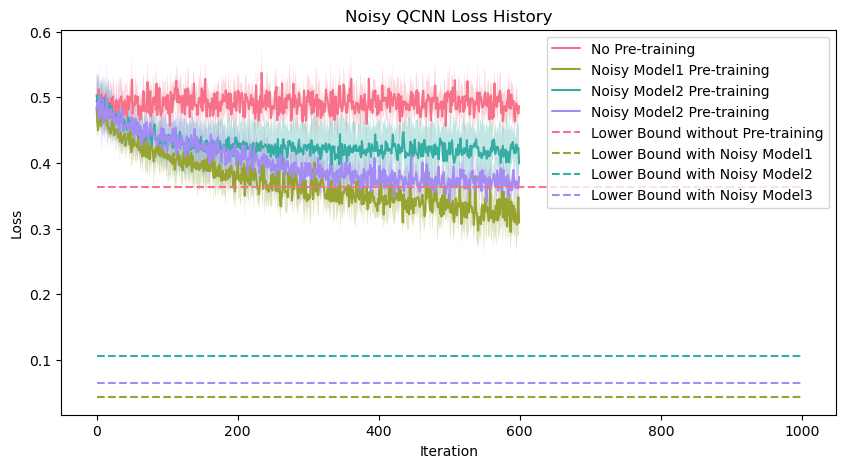

In [19]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(Not_trained_mean)), Not_trained_mean, label="No Pre-training", c=clrs[0])
    ax.fill_between(range(len(Not_trained_mean)), Not_trained_mean-Not_trained_std, Not_trained_mean+Not_trained_std, alpha=0.3,facecolor=clrs[0])

    ax.plot(range(len(Model1_Fidelity_mean)), Model1_Fidelity_mean, label="Noisy Model1 Pre-training", c=clrs[1])
    ax.fill_between(range(len(Model1_Fidelity_mean)), Model1_Fidelity_mean-Model1_Fidelity_std, Model1_Fidelity_mean+Model1_Fidelity_std, alpha=0.3,facecolor=clrs[1])
    
    ax.plot(range(len(Model2_Fidelity_mean)), Model2_Fidelity_mean, label="Noisy Model2 Pre-training", c=clrs[2])
    ax.fill_between(range(len(Model2_Fidelity_mean)), Model2_Fidelity_mean-Model2_Fidelity_std, Model2_Fidelity_mean+Model2_Fidelity_std, alpha=0.3,facecolor=clrs[2])

    ax.plot(range(len(Model3_Fidelity_mean)), Model3_Fidelity_mean, label="Noisy Model2 Pre-training", c=clrs[3])
    ax.fill_between(range(len(Model3_Fidelity_mean)), Model3_Fidelity_mean-Model3_Fidelity_std, Model3_Fidelity_mean+Model3_Fidelity_std, alpha=0.3,facecolor=clrs[3])


    ax.plot(range(1000), np.ones(1000) * LB_before_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound without Pre-training", c=clrs[0])
    ax.plot(range(1000), np.ones(1000) * LB_Model1_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound with Noisy Model1", c=clrs[1])
    ax.plot(range(1000), np.ones(1000) * LB_Model2_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound with Noisy Model2", c=clrs[2])
    ax.plot(range(1000), np.ones(1000) * LB_Model3_traindata, linestyle='dashed', linewidth=1.5, label="Lower Bound with Noisy Model3", c=clrs[3])


ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Noisy QCNN Loss History")
ax.legend()

In [20]:

print("Noisy QCNN classification accuracies:\n")
print("-------------------------------------\n")
print(f" Accuracy without pre-training: {accuracies_not_trained.mean()} ± {accuracies_not_trained.std()}")
print(f" Accuracy after pre-training with Noisy_Model1_Fidelity: {accuracies_Model1_Fidelity.mean()} ± {accuracies_Model1_Fidelity.std()}")
print(f" Accuracy after pre-training with Noisy_Model2_Fidelity: {accuracies_Model2_Fidelity.mean()} ± {accuracies_Model2_Fidelity.std()}")
print(f" Accuracy after pre-training with Noisy_Model3_Fidelity: {accuracies_Model3_Fidelity.mean()} ± {accuracies_Model3_Fidelity.std()}")

Noisy QCNN classification accuracies:

-------------------------------------

 Accuracy without pre-training: 0.5438297872340426 ± 0.01614060026147896
 Accuracy after pre-training with Noisy_Model1_Fidelity: 0.4902127659574468 ± 0.033086658319295754
 Accuracy after pre-training with Noisy_Model2_Fidelity: 0.5296453900709219 ± 0.013995271867612312
 Accuracy after pre-training with Noisy_Model3_Fidelity: 0.5042080378250591 ± 0.007279481514484238


Save the Loss Histories and Trained weights

In [21]:
f = open('/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noisy/Loss_histories_and_weights.txt', 'w')


for i in range(5):
    f.write(f'Loss History not trained {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_not_traiend[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights not trained {i + 1}:')
    f.write('\n')
    f.write(str(weights_not_trained[i]))
    

for i in range(5):
    f.write(f'Loss History Noisy Model1 Fidelity {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model1_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights Noisy Model1 Fidelity {i + 1}:')
    f.write('\n')
    f.write(str(weights_Model1_Fidelity[i]))


for i in range(5):
    f.write(f'Loss History Noisy Model2 Fidelity {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model2_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights Noisy Model2 Fidelity {i + 1}:')
    f.write('\n')
    f.write(str(weights_Model2_Fidelity[i]))


for i in range(5):
    f.write(f'Loss History Noisy Model3 Fidelity {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model3_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights Noisy Model3 Fidelity {i + 1}:')
    f.write('\n')
    f.write(str(weights_Model3_Fidelity[i]))
f.close()